In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from PIL import Image

lr = 3.0
size = 224
iterations = 2000
#Style and content weights can be modified accordingly to apply more or less of the style to the image
style_wt = 1e5
content_wt = 1.0

content_image_path = "../input/neural-style-transfer/content_2.jpg"
style_image_path = "../input//neural-style-transfer/style_3.jpg"

print("TensorFlow version:", tf.__version__)

style_layer_wts = [1.0, 0.5, 0.1, 0.1, 0.5]

TensorFlow version: 2.1.0


>We use the VGG model for the style transfer
There are basically 5 blocks in the model. Each block has some(>2) convolutional layers and a pooling(MaxPooling2D) layer

In [2]:
#We dont need the top layer of the VGG model, so we put include_top to False
model = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(size, size, 3))
#We dont want the model to update its parameters during out running. We just want its ouput
model.trainable = False
model.summary()

80142336/80134624 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [3]:
#The VGG model expects a 4 dimensional tensor
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(size, size))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return np.expand_dims(img, axis = 0)

In [4]:
#De processes images to display them in the notebook. This is
#Helpful when we need to display the generated images as that
#image will be in the format of this preprocessing. The generated image
#basically be in the rough form of an array. So to convert it
#to a image form, we have to deprocess it

#So this function exactly reverses whatever preprocess_input function does
def deprocess(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    #x[:, :, 1] += 100.00
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]#preprocess_input function inverts the order of the channles. So we are doing the opposite

    x = np.clip(x, 0, 255).astype('uint8')#Pixel values are between 0 and 255, so we clip our values to this range
    return x

#Will take in the processed image
def display_image(image):
    if len(image.shape) == 4:#As its a 4 dimension array
        #Remove the axis where it corresponds to number of examples
        image = image[0,:,:,:]#We expanded the dimensions during preprocessing, now we squeeze the dimensions

    img = deprocess(image)
    
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()

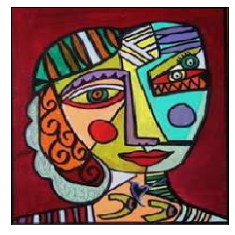

In [5]:
display_image(preprocess_image(style_image_path))

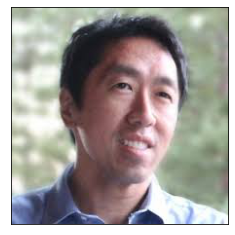

In [6]:
display_image(preprocess_image(content_image_path))

In order for us to compute content cost, we need to look at activations at some intermediate layers

In [7]:
#We take a deep layer as content layer. 2nd Convolutional layer of block 4, So complex features are alsready recognized 
content_layer = 'block4_conv2'

#To get output of intermediate layers, we have to create different models, with those intermediate layers as outputs
#So, input to these models will be same as input to VGG model, but output will be from the content layers
content_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)

In [8]:
#Some(shallower layers) will give us a broader style, while deeper layers, will give use a more comprehensive 
'''
style_layers = [
    'block1_conv1', 'block1_conv2',
    'block2_conv1', 'block2_conv2',
    'block3_conv1'
    ]
'''
style_layers=['block1_conv1','block3_conv1','block5_conv1']
#We use multiple blocks, as we want different types of style features to impact our cost

#To get output of intermediate layers, we have to create different models, with those intermediate layers as outputs
#So, input to these models will be same as input to VGG model, but output will be from the style layers
#As we have multiple layers for style, just make all the models into a list
style_models = [
    tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer).output)
    for layer in style_layers
]

In [9]:
x = preprocess_image(style_image_path)

temp_layer = 'block1_conv1'
temp_model = tf.keras.models.Model(model.input, model.get_layer(temp_layer).output)

out = temp_model.predict(x)[0]

print(out.shape)

(224, 224, 64)


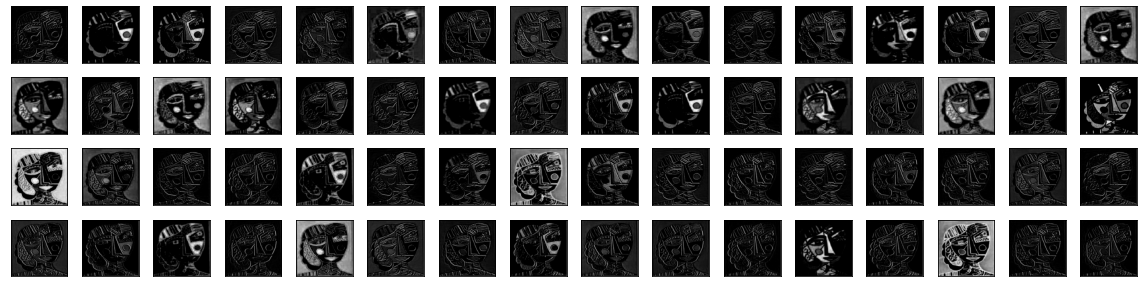

In [10]:
plt.figure(figsize=(16, 8))
for i in range(0, 64):
    plt.subplot(8, 16, i + 1)
    plt.imshow(out[:,:,i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [11]:
#We basically calculate Mean squared difference of the activations for content layer
#Is a good indicator of how close the extracted features of content images and generated images are at that particular content layer
def content_cost(content_img, generated_img):
    C = content_model(content_img)
    G = content_model(generated_img)
    cost = tf.reduce_mean(tf.square(C - G))
    return cost

In [12]:
#To compute style cost, we need gram matrices. We calculate gram matrices for the activations of the style and generated image
def gram_matrix(M):
    num_channels = tf.shape(M)[-1]#Finds out number of channels in the array M
    M = tf.reshape(M, shape=(-1, num_channels))#if array is 3 dimensional, we reshape it to 2 dimensional. If original rray is 200 by 200 by 3, it will be reshpaed to 200*200 by 3
    n = tf.shape(M)[0]
    G = tf.matmul(tf.transpose(M), M)#Gram matrice is basically matrix multiplication of A with its transpose
    return G / tf.cast(n, dtype=tf.float32)#We also scale it down by n(number of elements)

In [13]:
#We compute style cost with the help of gram matrices.
#We have lots of style model as given above, so our total style cost is going to be weighted sum of costs
def style_cost(style_img, generated_img):
    total_cost = 0
    
    for i, style_model in enumerate(style_models):
        S = style_model(style_img)#Activation for style image
        G = style_model(generated_img)#Activation for generated image
        GS = gram_matrix(S)#Calculate gram matrice for style image
        GG = gram_matrix(G)#Calculate gram matrice of generated image
        current_cost = style_layer_wts[i] * tf.reduce_mean(tf.square(GS - GG))
        total_cost += current_cost#Current style cost for each iteration is added to overall style cost
    
    total_cost /= (size * size * len(style_models))
    return total_cost

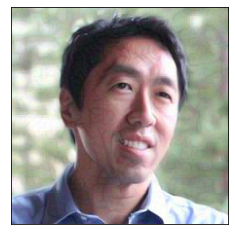

Iteration:0/2000, Total Cost:2319790080.0, Style Cost: 23197.900390625, Content Cost: 0.0
Iteration:1/2000, Total Cost:2163371520.0, Style Cost: 21633.26171875, Content Cost: 45364.37890625
Iteration:2/2000, Total Cost:1965928576.0, Style Cost: 19657.94140625, Content Cost: 134356.9375
Iteration:3/2000, Total Cost:1738710912.0, Style Cost: 17384.88671875, Content Cost: 222247.21875
Iteration:4/2000, Total Cost:1490476672.0, Style Cost: 14901.7451171875, Content Cost: 302244.8125
Iteration:5/2000, Total Cost:1232229632.0, Style Cost: 12318.525390625, Content Cost: 377061.5
Iteration:6/2000, Total Cost:981940672.0, Style Cost: 9814.9130859375, Content Cost: 449322.75
Iteration:7/2000, Total Cost:764057344.0, Style Cost: 7635.37939453125, Content Cost: 519420.90625
Iteration:8/2000, Total Cost:603467456.0, Style Cost: 6028.81396484375, Content Cost: 586031.25
Iteration:9/2000, Total Cost:514197792.0, Style Cost: 5135.509765625, Content Cost: 646826.875
Iteration:10/2000, Total Cost:483360

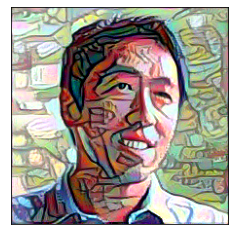

Iteration:100/2000, Total Cost:27334268.0, Style Cost: 265.5338134765625, Content Cost: 780885.5
Iteration:101/2000, Total Cost:27088966.0, Style Cost: 263.0741271972656, Content Cost: 781554.75
Iteration:102/2000, Total Cost:26848930.0, Style Cost: 260.66668701171875, Content Cost: 782261.9375
Iteration:103/2000, Total Cost:26613430.0, Style Cost: 258.3042297363281, Content Cost: 783007.6875
Iteration:104/2000, Total Cost:26382276.0, Style Cost: 255.9849853515625, Content Cost: 783777.875
Iteration:105/2000, Total Cost:26156040.0, Style Cost: 253.71481323242188, Content Cost: 784557.0625
Iteration:106/2000, Total Cost:25934748.0, Style Cost: 251.49423217773438, Content Cost: 785323.8125
Iteration:107/2000, Total Cost:25718190.0, Style Cost: 249.32135009765625, Content Cost: 786054.6875
Iteration:108/2000, Total Cost:25506252.0, Style Cost: 247.195068359375, Content Cost: 786745.25
Iteration:109/2000, Total Cost:25298374.0, Style Cost: 245.1096954345703, Content Cost: 787404.0
Iteratio

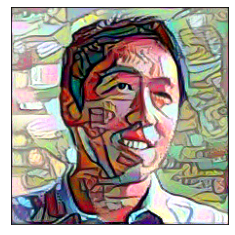

Iteration:200/2000, Total Cost:15342666.0, Style Cost: 145.1242218017578, Content Cost: 830243.9375
Iteration:201/2000, Total Cost:15282350.0, Style Cost: 144.5179901123047, Content Cost: 830550.9375
Iteration:202/2000, Total Cost:15222581.0, Style Cost: 143.9172821044922, Content Cost: 830852.625
Iteration:203/2000, Total Cost:15163248.0, Style Cost: 143.32090759277344, Content Cost: 831156.5625
Iteration:204/2000, Total Cost:15104530.0, Style Cost: 142.73068237304688, Content Cost: 831461.9375
Iteration:205/2000, Total Cost:15046262.0, Style Cost: 142.14492797851562, Content Cost: 831768.75
Iteration:206/2000, Total Cost:14988588.0, Style Cost: 141.5651397705078, Content Cost: 832073.9375
Iteration:207/2000, Total Cost:14931396.0, Style Cost: 140.990234375, Content Cost: 832373.125
Iteration:208/2000, Total Cost:14874856.0, Style Cost: 140.42185974121094, Content Cost: 832669.875
Iteration:209/2000, Total Cost:14818742.0, Style Cost: 139.85777282714844, Content Cost: 832965.125
Itera

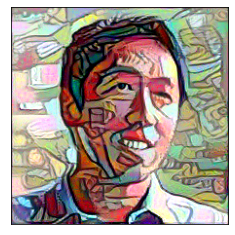

Iteration:300/2000, Total Cost:11146979.0, Style Cost: 102.89517974853516, Content Cost: 857460.5625
Iteration:301/2000, Total Cost:11118105.0, Style Cost: 102.60407257080078, Content Cost: 857697.6875
Iteration:302/2000, Total Cost:11089374.0, Style Cost: 102.3143081665039, Content Cost: 857943.5
Iteration:303/2000, Total Cost:11060862.0, Style Cost: 102.02670288085938, Content Cost: 858191.5
Iteration:304/2000, Total Cost:11032511.0, Style Cost: 101.74073028564453, Content Cost: 858438.4375
Iteration:305/2000, Total Cost:11004330.0, Style Cost: 101.45645904541016, Content Cost: 858684.0625
Iteration:306/2000, Total Cost:10976343.0, Style Cost: 101.1742172241211, Content Cost: 858921.0625
Iteration:307/2000, Total Cost:10948581.0, Style Cost: 100.89425659179688, Content Cost: 859154.625
Iteration:308/2000, Total Cost:10920956.0, Style Cost: 100.61573028564453, Content Cost: 859383.5
Iteration:309/2000, Total Cost:10893473.0, Style Cost: 100.33861541748047, Content Cost: 859611.125
Ite

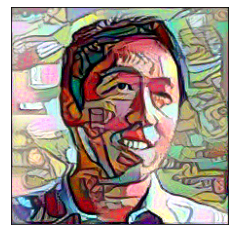

Iteration:400/2000, Total Cost:8950642.0, Style Cost: 80.71780395507812, Content Cost: 878861.6875
Iteration:401/2000, Total Cost:8933992.0, Style Cost: 80.54967498779297, Content Cost: 879024.875
Iteration:402/2000, Total Cost:8917422.0, Style Cost: 80.38235473632812, Content Cost: 879186.0625
Iteration:403/2000, Total Cost:8900938.0, Style Cost: 80.21592712402344, Content Cost: 879345.9375
Iteration:404/2000, Total Cost:8884524.0, Style Cost: 80.05021667480469, Content Cost: 879502.6875
Iteration:405/2000, Total Cost:8868220.0, Style Cost: 79.88561248779297, Content Cost: 879658.9375
Iteration:406/2000, Total Cost:8851959.0, Style Cost: 79.72140502929688, Content Cost: 879818.375
Iteration:407/2000, Total Cost:8835765.0, Style Cost: 79.55786895751953, Content Cost: 879978.1875
Iteration:408/2000, Total Cost:8819608.0, Style Cost: 79.39470672607422, Content Cost: 880137.0625
Iteration:409/2000, Total Cost:8803493.0, Style Cost: 79.2319564819336, Content Cost: 880297.5625
Iteration:410

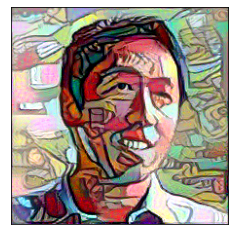

Iteration:500/2000, Total Cost:7607042.0, Style Cost: 67.16757202148438, Content Cost: 890284.75
Iteration:501/2000, Total Cost:7596114.5, Style Cost: 67.05746459960938, Content Cost: 890368.1875
Iteration:502/2000, Total Cost:7585235.0, Style Cost: 66.94782257080078, Content Cost: 890452.3125
Iteration:503/2000, Total Cost:7574399.0, Style Cost: 66.83867645263672, Content Cost: 890531.5625
Iteration:504/2000, Total Cost:7563619.0, Style Cost: 66.73011779785156, Content Cost: 890606.875
Iteration:505/2000, Total Cost:7552856.0, Style Cost: 66.62174987792969, Content Cost: 890680.8125
Iteration:506/2000, Total Cost:7542110.5, Style Cost: 66.51349639892578, Content Cost: 890761.0
Iteration:507/2000, Total Cost:7531403.5, Style Cost: 66.40557861328125, Content Cost: 890845.375
Iteration:508/2000, Total Cost:7520720.5, Style Cost: 66.29789733886719, Content Cost: 890931.1875
Iteration:509/2000, Total Cost:7510057.0, Style Cost: 66.19038391113281, Content Cost: 891018.75
Iteration:510/2000,

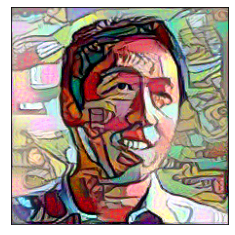

Iteration:600/2000, Total Cost:6674628.0, Style Cost: 57.766075134277344, Content Cost: 898020.625
Iteration:601/2000, Total Cost:6666754.5, Style Cost: 57.68666458129883, Content Cost: 898087.8125
Iteration:602/2000, Total Cost:6658936.0, Style Cost: 57.60784149169922, Content Cost: 898152.25
Iteration:603/2000, Total Cost:6651127.0, Style Cost: 57.52912521362305, Content Cost: 898214.6875
Iteration:604/2000, Total Cost:6643349.0, Style Cost: 57.450775146484375, Content Cost: 898271.375
Iteration:605/2000, Total Cost:6635612.0, Style Cost: 57.372886657714844, Content Cost: 898323.75
Iteration:606/2000, Total Cost:6627888.0, Style Cost: 57.295101165771484, Content Cost: 898378.0625
Iteration:607/2000, Total Cost:6620178.0, Style Cost: 57.21744155883789, Content Cost: 898433.9375
Iteration:608/2000, Total Cost:6612469.5, Style Cost: 57.139827728271484, Content Cost: 898486.5
Iteration:609/2000, Total Cost:6604789.5, Style Cost: 57.062538146972656, Content Cost: 898535.4375
Iteration:610

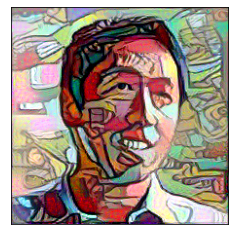

Iteration:700/2000, Total Cost:5988942.5, Style Cost: 50.85890579223633, Content Cost: 903052.1875
Iteration:701/2000, Total Cost:5982991.0, Style Cost: 50.79898452758789, Content Cost: 903092.75
Iteration:702/2000, Total Cost:5977051.0, Style Cost: 50.739192962646484, Content Cost: 903131.5625
Iteration:703/2000, Total Cost:5971116.5, Style Cost: 50.67949676513672, Content Cost: 903166.9375
Iteration:704/2000, Total Cost:5965182.5, Style Cost: 50.619876861572266, Content Cost: 903195.1875
Iteration:705/2000, Total Cost:5959264.0, Style Cost: 50.560394287109375, Content Cost: 903224.5
Iteration:706/2000, Total Cost:5953355.0, Style Cost: 50.50095748901367, Content Cost: 903259.75
Iteration:707/2000, Total Cost:5947454.5, Style Cost: 50.44157409667969, Content Cost: 903296.875
Iteration:708/2000, Total Cost:5941570.5, Style Cost: 50.38242721557617, Content Cost: 903328.1875
Iteration:709/2000, Total Cost:5935712.0, Style Cost: 50.32355880737305, Content Cost: 903355.8125
Iteration:710/2

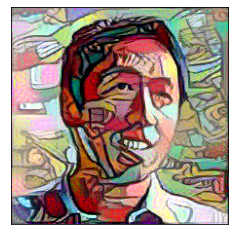

Iteration:800/2000, Total Cost:5457609.5, Style Cost: 45.51497268676758, Content Cost: 906112.0625
Iteration:801/2000, Total Cost:5452914.5, Style Cost: 45.467872619628906, Content Cost: 906126.9375
Iteration:802/2000, Total Cost:5448225.0, Style Cost: 45.420772552490234, Content Cost: 906147.75
Iteration:803/2000, Total Cost:5443539.0, Style Cost: 45.37373733520508, Content Cost: 906165.6875
Iteration:804/2000, Total Cost:5438880.0, Style Cost: 45.32703399658203, Content Cost: 906176.25
Iteration:805/2000, Total Cost:5434227.5, Style Cost: 45.28046798706055, Content Cost: 906180.4375
Iteration:806/2000, Total Cost:5429580.5, Style Cost: 45.233951568603516, Content Cost: 906185.3125
Iteration:807/2000, Total Cost:5424958.0, Style Cost: 45.18760299682617, Content Cost: 906197.25
Iteration:808/2000, Total Cost:5420354.0, Style Cost: 45.14137268066406, Content Cost: 906216.75
Iteration:809/2000, Total Cost:5415768.0, Style Cost: 45.09531021118164, Content Cost: 906236.875
Iteration:810/20

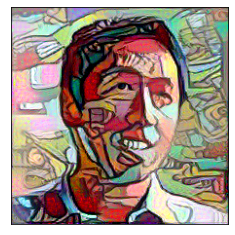

Iteration:900/2000, Total Cost:5025434.5, Style Cost: 41.183570861816406, Content Cost: 907077.3125
Iteration:901/2000, Total Cost:5021453.0, Style Cost: 41.143577575683594, Content Cost: 907095.375
Iteration:902/2000, Total Cost:5017497.0, Style Cost: 41.103759765625, Content Cost: 907120.75
Iteration:903/2000, Total Cost:5013540.5, Style Cost: 41.06392288208008, Content Cost: 907148.25
Iteration:904/2000, Total Cost:5009601.0, Style Cost: 41.02428436279297, Content Cost: 907172.3125
Iteration:905/2000, Total Cost:5005666.0, Style Cost: 40.98472213745117, Content Cost: 907193.5
Iteration:906/2000, Total Cost:5001746.0, Style Cost: 40.94536590576172, Content Cost: 907209.25
Iteration:907/2000, Total Cost:4997839.0, Style Cost: 40.9061279296875, Content Cost: 907226.375
Iteration:908/2000, Total Cost:4993952.5, Style Cost: 40.86715316772461, Content Cost: 907237.125
Iteration:909/2000, Total Cost:4990080.5, Style Cost: 40.82839584350586, Content Cost: 907241.125
Iteration:910/2000, Tota

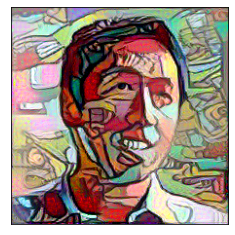

Iteration:1000/2000, Total Cost:4668945.5, Style Cost: 37.602783203125, Content Cost: 908667.125
Iteration:1001/2000, Total Cost:4665760.0, Style Cost: 37.570838928222656, Content Cost: 908676.1875
Iteration:1002/2000, Total Cost:4662574.5, Style Cost: 37.538970947265625, Content Cost: 908677.375
Iteration:1003/2000, Total Cost:4659390.5, Style Cost: 37.507118225097656, Content Cost: 908678.75
Iteration:1004/2000, Total Cost:4656217.0, Style Cost: 37.47529602050781, Content Cost: 908687.375
Iteration:1005/2000, Total Cost:4653062.0, Style Cost: 37.44364929199219, Content Cost: 908696.875
Iteration:1006/2000, Total Cost:4649910.0, Style Cost: 37.412025451660156, Content Cost: 908707.6875
Iteration:1007/2000, Total Cost:4646758.0, Style Cost: 37.38031768798828, Content Cost: 908726.0625
Iteration:1008/2000, Total Cost:4643615.5, Style Cost: 37.3487548828125, Content Cost: 908740.1875
Iteration:1009/2000, Total Cost:4640478.0, Style Cost: 37.317291259765625, Content Cost: 908748.875
Itera

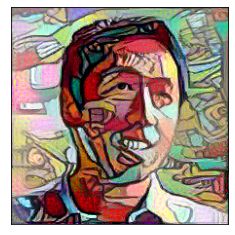

Iteration:1100/2000, Total Cost:4376910.5, Style Cost: 34.67273712158203, Content Cost: 909636.625
Iteration:1101/2000, Total Cost:4374175.0, Style Cost: 34.64543151855469, Content Cost: 909631.8125
Iteration:1102/2000, Total Cost:4371458.0, Style Cost: 34.618343353271484, Content Cost: 909623.8125
Iteration:1103/2000, Total Cost:4368750.5, Style Cost: 34.59130859375, Content Cost: 909619.6875
Iteration:1104/2000, Total Cost:4366040.0, Style Cost: 34.56418228149414, Content Cost: 909621.6875
Iteration:1105/2000, Total Cost:4363341.5, Style Cost: 34.53718566894531, Content Cost: 909623.125
Iteration:1106/2000, Total Cost:4360650.0, Style Cost: 34.5102653503418, Content Cost: 909623.4375
Iteration:1107/2000, Total Cost:4357956.5, Style Cost: 34.48329162597656, Content Cost: 909627.125
Iteration:1108/2000, Total Cost:4355274.0, Style Cost: 34.45634841918945, Content Cost: 909639.375
Iteration:1109/2000, Total Cost:4352594.0, Style Cost: 34.429534912109375, Content Cost: 909640.25
Iteratio

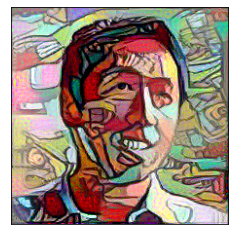

Iteration:1200/2000, Total Cost:4125392.25, Style Cost: 32.15559768676758, Content Cost: 909832.4375
Iteration:1201/2000, Total Cost:4123049.0, Style Cost: 32.1319580078125, Content Cost: 909853.3125
Iteration:1202/2000, Total Cost:4120735.25, Style Cost: 32.10871887207031, Content Cost: 909863.1875
Iteration:1203/2000, Total Cost:4118428.0, Style Cost: 32.085693359375, Content Cost: 909858.75
Iteration:1204/2000, Total Cost:4116109.5, Style Cost: 32.0624885559082, Content Cost: 909860.75
Iteration:1205/2000, Total Cost:4113807.75, Style Cost: 32.03927993774414, Content Cost: 909879.8125
Iteration:1206/2000, Total Cost:4111505.5, Style Cost: 32.016075134277344, Content Cost: 909897.875
Iteration:1207/2000, Total Cost:4109198.5, Style Cost: 31.992891311645508, Content Cost: 909909.375
Iteration:1208/2000, Total Cost:4106896.5, Style Cost: 31.96992301940918, Content Cost: 909904.25
Iteration:1209/2000, Total Cost:4104602.75, Style Cost: 31.947032928466797, Content Cost: 909899.5
Iteratio

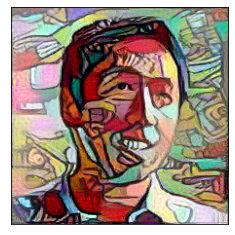

Iteration:1300/2000, Total Cost:3908658.0, Style Cost: 29.981122970581055, Content Cost: 910545.6875
Iteration:1301/2000, Total Cost:3906628.75, Style Cost: 29.96072769165039, Content Cost: 910556.0625
Iteration:1302/2000, Total Cost:3904615.0, Style Cost: 29.9404296875, Content Cost: 910572.0
Iteration:1303/2000, Total Cost:3902593.0, Style Cost: 29.920087814331055, Content Cost: 910584.25
Iteration:1304/2000, Total Cost:3900579.5, Style Cost: 29.899816513061523, Content Cost: 910597.625
Iteration:1305/2000, Total Cost:3898562.25, Style Cost: 29.879470825195312, Content Cost: 910615.1875
Iteration:1306/2000, Total Cost:3896560.5, Style Cost: 29.8592529296875, Content Cost: 910635.125
Iteration:1307/2000, Total Cost:3894553.25, Style Cost: 29.839054107666016, Content Cost: 910647.8125
Iteration:1308/2000, Total Cost:3892550.0, Style Cost: 29.818920135498047, Content Cost: 910658.0625
Iteration:1309/2000, Total Cost:3890557.0, Style Cost: 29.798810958862305, Content Cost: 910676.0
Itera

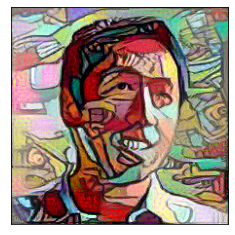

Iteration:1400/2000, Total Cost:3719467.0, Style Cost: 28.084489822387695, Content Cost: 911017.9375
Iteration:1401/2000, Total Cost:3717692.5, Style Cost: 28.066631317138672, Content Cost: 911029.375
Iteration:1402/2000, Total Cost:3715932.5, Style Cost: 28.048871994018555, Content Cost: 911045.375
Iteration:1403/2000, Total Cost:3714173.5, Style Cost: 28.031143188476562, Content Cost: 911059.1875
Iteration:1404/2000, Total Cost:3712419.0, Style Cost: 28.013551712036133, Content Cost: 911063.75
Iteration:1405/2000, Total Cost:3710661.0, Style Cost: 27.995981216430664, Content Cost: 911062.875
Iteration:1406/2000, Total Cost:3708907.25, Style Cost: 27.9783992767334, Content Cost: 911067.25
Iteration:1407/2000, Total Cost:3707167.75, Style Cost: 27.960914611816406, Content Cost: 911076.1875
Iteration:1408/2000, Total Cost:3705423.0, Style Cost: 27.943416595458984, Content Cost: 911081.375
Iteration:1409/2000, Total Cost:3703681.0, Style Cost: 27.925893783569336, Content Cost: 911091.5
I

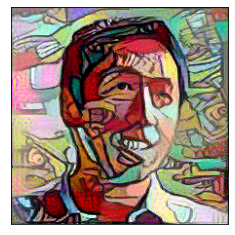

Iteration:1500/2000, Total Cost:3552998.5, Style Cost: 26.416166305541992, Content Cost: 911381.875
Iteration:1501/2000, Total Cost:3551429.25, Style Cost: 26.400493621826172, Content Cost: 911379.9375
Iteration:1502/2000, Total Cost:3549852.0, Style Cost: 26.38479232788086, Content Cost: 911372.875
Iteration:1503/2000, Total Cost:3548273.5, Style Cost: 26.369110107421875, Content Cost: 911362.375
Iteration:1504/2000, Total Cost:3546709.75, Style Cost: 26.353546142578125, Content Cost: 911355.1875
Iteration:1505/2000, Total Cost:3545132.0, Style Cost: 26.337778091430664, Content Cost: 911354.3125
Iteration:1506/2000, Total Cost:3543551.25, Style Cost: 26.321908950805664, Content Cost: 911360.1875
Iteration:1507/2000, Total Cost:3541995.5, Style Cost: 26.30629539489746, Content Cost: 911365.875
Iteration:1508/2000, Total Cost:3540419.5, Style Cost: 26.290590286254883, Content Cost: 911360.5625
Iteration:1509/2000, Total Cost:3538851.5, Style Cost: 26.274982452392578, Content Cost: 91135

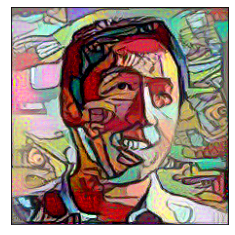

Iteration:1600/2000, Total Cost:3402348.0, Style Cost: 24.914356231689453, Content Cost: 910912.5625
Iteration:1601/2000, Total Cost:3400936.0, Style Cost: 24.900278091430664, Content Cost: 910908.3125
Iteration:1602/2000, Total Cost:3399513.0, Style Cost: 24.886043548583984, Content Cost: 910908.875
Iteration:1603/2000, Total Cost:3398101.5, Style Cost: 24.87197494506836, Content Cost: 910903.9375
Iteration:1604/2000, Total Cost:3396689.25, Style Cost: 24.857927322387695, Content Cost: 910896.4375
Iteration:1605/2000, Total Cost:3395278.5, Style Cost: 24.84385871887207, Content Cost: 910892.8125
Iteration:1606/2000, Total Cost:3393884.5, Style Cost: 24.829975128173828, Content Cost: 910886.9375
Iteration:1607/2000, Total Cost:3392473.5, Style Cost: 24.815967559814453, Content Cost: 910876.75
Iteration:1608/2000, Total Cost:3391068.5, Style Cost: 24.80196762084961, Content Cost: 910871.8125
Iteration:1609/2000, Total Cost:3389676.5, Style Cost: 24.788049697875977, Content Cost: 910871.

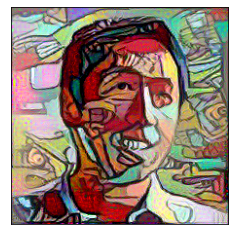

Iteration:1700/2000, Total Cost:3269325.0, Style Cost: 23.58820915222168, Content Cost: 910504.0625
Iteration:1701/2000, Total Cost:3268074.25, Style Cost: 23.575666427612305, Content Cost: 910507.4375
Iteration:1702/2000, Total Cost:3266819.0, Style Cost: 23.563182830810547, Content Cost: 910500.75
Iteration:1703/2000, Total Cost:3265561.25, Style Cost: 23.5506591796875, Content Cost: 910495.25
Iteration:1704/2000, Total Cost:3264308.75, Style Cost: 23.53814697265625, Content Cost: 910494.0625
Iteration:1705/2000, Total Cost:3263061.0, Style Cost: 23.52568244934082, Content Cost: 910492.8125
Iteration:1706/2000, Total Cost:3261803.5, Style Cost: 23.51317024230957, Content Cost: 910486.625
Iteration:1707/2000, Total Cost:3260560.75, Style Cost: 23.500808715820312, Content Cost: 910480.0625
Iteration:1708/2000, Total Cost:3259317.0, Style Cost: 23.48835563659668, Content Cost: 910481.5625
Iteration:1709/2000, Total Cost:3258075.0, Style Cost: 23.475833892822266, Content Cost: 910491.375

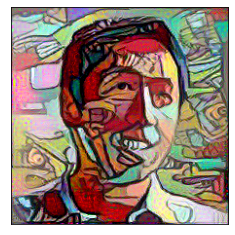

Iteration:1800/2000, Total Cost:3150173.0, Style Cost: 22.3991756439209, Content Cost: 910255.5
Iteration:1801/2000, Total Cost:3149022.5, Style Cost: 22.38774871826172, Content Cost: 910247.6875
Iteration:1802/2000, Total Cost:3147870.5, Style Cost: 22.37622833251953, Content Cost: 910247.75
Iteration:1803/2000, Total Cost:3146733.25, Style Cost: 22.364768981933594, Content Cost: 910256.1875
Iteration:1804/2000, Total Cost:3145577.75, Style Cost: 22.353069305419922, Content Cost: 910270.6875
Iteration:1805/2000, Total Cost:3144443.75, Style Cost: 22.341609954833984, Content Cost: 910282.75
Iteration:1806/2000, Total Cost:3143292.5, Style Cost: 22.330013275146484, Content Cost: 910291.25
Iteration:1807/2000, Total Cost:3142142.5, Style Cost: 22.31851577758789, Content Cost: 910291.125
Iteration:1808/2000, Total Cost:3141007.5, Style Cost: 22.30718994140625, Content Cost: 910288.625
Iteration:1809/2000, Total Cost:3139870.5, Style Cost: 22.295745849609375, Content Cost: 910295.9375
Iter

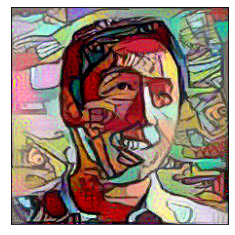

Iteration:1900/2000, Total Cost:3039852.5, Style Cost: 21.297536849975586, Content Cost: 910098.75
Iteration:1901/2000, Total Cost:3038810.5, Style Cost: 21.287189483642578, Content Cost: 910091.4375
Iteration:1902/2000, Total Cost:3037760.25, Style Cost: 21.276681900024414, Content Cost: 910092.0625
Iteration:1903/2000, Total Cost:3036709.0, Style Cost: 21.26617431640625, Content Cost: 910091.5625
Iteration:1904/2000, Total Cost:3035660.0, Style Cost: 21.255727767944336, Content Cost: 910087.375
Iteration:1905/2000, Total Cost:3034623.0, Style Cost: 21.245403289794922, Content Cost: 910082.6875
Iteration:1906/2000, Total Cost:3033574.5, Style Cost: 21.235029220581055, Content Cost: 910071.5625
Iteration:1907/2000, Total Cost:3032534.25, Style Cost: 21.224655151367188, Content Cost: 910068.8125
Iteration:1908/2000, Total Cost:3031493.0, Style Cost: 21.21413803100586, Content Cost: 910079.125
Iteration:1909/2000, Total Cost:3030453.25, Style Cost: 21.20372200012207, Content Cost: 910081

In [14]:
import time
content_image_preprocessed = preprocess_image(content_image_path)
style_image_preprocessed = preprocess_image(style_image_path)
generated_image = tf.Variable(content_image_preprocessed, dtype=tf.float32)#The first generated image can be a random image, but we'll get quicker results if we take first generated image as content image
generated_images = []
costs = []

optimizer = tf.optimizers.Adam(learning_rate=lr)#We use the ADAM optimizer
start_time=time.time()
for i in range(iterations):
    
    with tf.GradientTape() as tape:
        J_content = content_cost(content_img=content_image_preprocessed, generated_img=generated_image)#Returns style cost
        J_style = style_cost(style_img=style_image_preprocessed, generated_img=generated_image)#Returns content cost
        J_total = content_wt * J_content + style_wt * J_style#Total cost where style and content cost are multiplied by their respective weights
    
    gradients = tape.gradient(J_total, generated_image)#Calculate gradient on the total cost wrt the generated image
    optimizer.apply_gradients([(gradients, generated_image)])
    
    costs.append(J_total.numpy())
    
    if i % 100 == 0:
        display_image(generated_image.numpy())
        generated_images.append(generated_image.numpy())
    print("Iteration:{}/{}, Total Cost:{}, Style Cost: {}, Content Cost: {}".format(i, iterations, J_total, J_style, J_content))
print(time.time()-start_time)

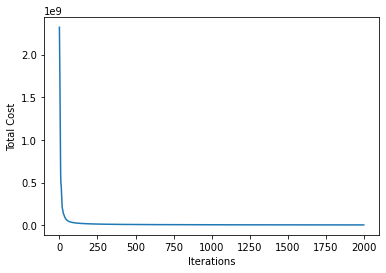

In [15]:
plt.plot(range(iterations), costs)
plt.xlabel("Iterations")
plt.ylabel("Total Cost")
plt.show()

In [16]:
image = Image.fromarray(deprocess(generated_images[-1][0]))

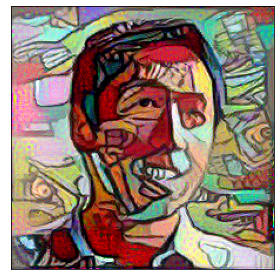

In [17]:
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('xyz.png')